## **Applied Project 2: RLHF**

> **实践方向 (practical track)**  
> 你需要在以下 **OpenAI-Gym** 环境中测试不同的 RLHF 算法：  
> `CartPole`、`MountainCar`、`MountainCarContinuous`、`Acrobot` 以及 `Pendulum` 
> 实验应按下列步骤进行：

---

### **1.Trajectory generation 轨迹生成**

1. **训练优良策略 π₁**  
   使用你选择的任意强化学习算法，在目标环境中训练出一个可以 **稳定获得接近最高总回报** 的策略 π₁

2. **保存次优策略 π₂**  
   在训练过程中保留一个中途模型作为策略 π₂，使其总回报 `≈ ½` × （最高可达总回报）

3. **构造偏好数据集**  
   - 生成 `K` 对「首选轨迹 / 被拒轨迹」
   - 对于每一对：  
     - 用 π₁ 采样得到轨迹 `τ₁`，用 π₂ 采样得到轨迹 `τ₂`
     - 设 `R(τ)` 为轨迹 τ 的总回报，则**以下概率**判定 `τ₁` 为「首选」：  

       $$
       P\bigl(\text{τ₁ 为首选}\bigr)=
       \frac{\exp\bigl(R(\tau_1)\bigr)}
            {\exp\bigl(R(\tau_1)\bigr)+\exp\bigl(R(\tau_2)\bigr)}
       $$

---

### **2.Run RLHF 运行RLHF算法**

比较 **DPO**（Direct Preference Optimization）与 **PPO-RLHF**，并在 **至少两个** 上述环境中，针对 **不同规模的偏好数据集** 进行对比实验

> **重要说明**：  
> 每一张结果图都必须报告 **≥ 3 个随机种子** 的平均性能


In [12]:
import os
import gymnasium as gym
import datetime
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.monitor import Monitor
from tools import *

In [ ]:
# 设置日志文件夹
# Set the log folder
log_path = os.path.join("Training", "Logs")
if not os.path.exists(log_path):
    os.makedirs(log_path)

################################################################################################
# 创建 Env
# Create the environment
env = gym.make("CartPole-v1")
env = Monitor(env, log_path)    # Monitor the environment for logging
env = DummyVecEnv([lambda: env])  # Wrap the environment in a DummyVecEnv

# 创建 PPO Agent
# Create the PPO agent
model = PPO(policy = "MlpPolicy", 
            env = env, 
            device = "cpu",                  # use device "cpu"                           # 设备类型 "cuda"， 这种情况官方建议使用 cpu
            verbose = 1,                     # Log type                                   # 日志类型
            tensorboard_log = log_path)    # Tensorboard log folder location            # Tensorboard 日志文件夹位置                  

################################################################################################
# 当奖励到达 200 就停止训练
# Stop training when the reward reaches 200

save_path_callback = os.path.join("Training", "Saved Models", "PPO_CartPole_Cut")

# 训练暂停的回调函数
# Callback function to stop training
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=500, 
                                              verbose=1)
# 训练评估的回调函数
# Callback function for training evaluation
eval_callback = EvalCallback(env,
                             callback_on_new_best=stop_callback,            # 评估回调函数          # callback function for evaluation
                             eval_freq=1000,                                # 每 10000 步评估一次   # Evaluate every 10000 steps
                             best_model_save_path=save_path_callback,       # 最佳模型保存路径      # Best model save path
                             verbose=1)

print("Log path:  ", log_path)
print("Save path: ", save_path_callback)

Using cpu device
Log path:   Training\Logs
Save path:  Training\Saved Models\PPO_CartPole_Cut


In [8]:
# 开始训练
# Start training
model.learn(total_timesteps = 20000)

# 保存模型
# Save the model
PPO_Path = os.path.join("Training", "Saved Models", "PPO_CartPole")
model.save(PPO_Path)

Logging to Training\Logs\PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.6     |
|    ep_rew_mean     | 21.6     |
| time/              |          |
|    fps             | 1736     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.4        |
|    ep_rew_mean          | 27.4        |
| time/                   |             |
|    fps                  | 1184        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008539616 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | 0.00329     |

In [9]:
# 评估模型
# Test the model
test_model("PPO", PPO_Path, n_episodes=5)

Training\Saved Models\PPO_CartPole
Episode: 1 Score: [500.]
Episode: 2 Score: [500.]
Episode: 3 Score: [500.]
Episode: 4 Score: [171.]
Episode: 5 Score: [177.]


In [16]:
%load_ext tensorboard
%tensorboard --logdir Training/Logs/PPO_2 --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 45516), started 0:02:27 ago. (Use '!kill 45516' to kill it.)

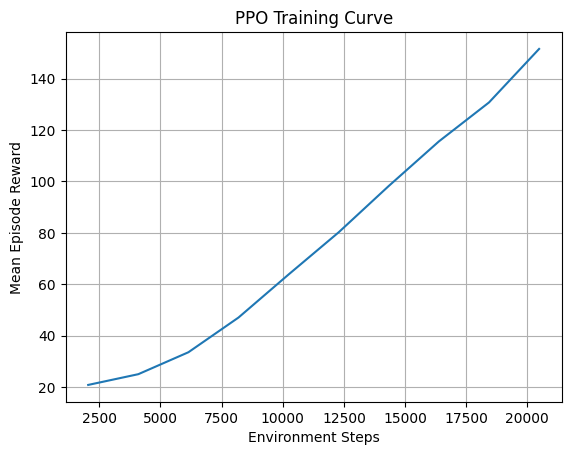

In [17]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

# 指向你的日志文件夹
log_dir = "Training/Logs/PPO_2"

# 读取所有标量
ea = event_accumulator.EventAccumulator(log_dir,
                                        size_guidance={  # 限制一次性读多少记录
                                          'scalars': 10000,
                                        })
ea.Reload()

# 拿到 “rollout/ep_rew_mean” 曲线
rew = ea.Scalars('rollout/ep_rew_mean')
steps = [x.step for x in rew]
values = [x.value for x in rew]

# 画图
plt.plot(steps, values)
plt.xlabel("Environment Steps")
plt.ylabel("Mean Episode Reward")
plt.title("PPO Training Curve")
plt.grid(True)
plt.show()
